In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

#Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix, classification_report

#Método de Filtro
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif

import pickle
from collections import Counter

import lightgbm as lgb

from bayes_opt import BayesianOptimization

import shap

#sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.3f}'.format

Importa dados utilizando função que reduz o uso de memória

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = reduce_mem_usage(pd.read_csv('ABT_ABT_TARGET.csv'))

Mem. usage decreased to 232.52 Mb (2.9% reduction)


Cria variável target e preenche dados vazios

In [4]:
df['TARGET'] =  (df['TARGET_MT9']+df['TARGET_LP9']).apply(lambda x: 1 if x>0 else 0)
df['PC_FORMACAO_DOCENTE_FINAL'].fillna(df['PC_FORMACAO_DOCENTE_FINAL'].mean(),inplace=True)

Define variáveis que serão usadas no modelo

In [5]:
inicio = df.columns.get_loc('TX_RESP_Q007')
fim = df.columns.get_loc('PROF_TX_RESP_Q125')+1

colunas = ['ID_PROVA_BRASIL', 'TARGET', 'ID_MUNICIPIO', 'ID_DEPENDENCIA_ADM', 'ID_LOCALIZACAO', 'PC_FORMACAO_DOCENTE_FINAL',
'NU_MATRICULADOS_CENSO_9EF', 'TAXA_PARTICIPACAO_9EF'] + df.iloc[:,inicio:fim].columns.tolist()

In [6]:
#cria df apenas com as variáveis que quero
df_vars = df[colunas]

Entendendo preenchimento das variáveis

In [7]:
print("Linhas totais: ", len(df_vars), "\nLinhas com algum dado nulo: ", len(df_vars[df_vars.isnull().values.any(axis=1)]))

Linhas totais:  98992 
Linhas com algum dado nulo:  97045


Avaliando variáveis do questionário

In [8]:
df_tx = df_vars.filter(like="TX_RESP_Q")
print("Quantidade de variáveis dos questionários: ", df_tx.shape[1])

Quantidade de variáveis dos questionários:  304


In [9]:
#separa um def com o percentual de colunas de questionário nulas / total de colunas 
df_tx_null = df_tx.isnull().sum(axis=1)/(df_tx.shape[1])
df_tx_null.describe()

count   98,992.000
mean         0.071
std          0.130
min          0.000
25%          0.020
50%          0.023
75%          0.033
max          1.000
dtype: float64

In [10]:
#define limite de corte para exclusão de linhas com dados nulos
limite = df_tx_null.mean()

In [11]:
print("Limite percentual de colunas nulas na linha (média do total de linhas): {:3.2f}% \nLinhas com dados nulos acima do limite: \nQtd: {}\n% {:3.2f}".format(limite*100, df_vars[df_tx_null >= limite]['TARGET'].count(), (df_vars[df_tx_null >= limite]['TARGET'].count()/len(df_vars))*100))

Limite percentual de colunas nulas na linha (média do total de linhas): 7.06% 
Linhas com dados nulos acima do limite: 
Qtd: 13811
% 13.95


Remove linhas acima do limite

In [12]:
df_limpo = df_vars.drop(df_vars[df_tx_null >= limite].index)

Separa variáveis categóricas e cria LabelEncoder delas

In [13]:
categoricas = df_limpo.iloc[:,df_limpo.columns.get_loc('TX_RESP_Q007'):].columns
categoricas

Index(['TX_RESP_Q007', 'TX_RESP_Q008', 'TX_RESP_Q009', 'TX_RESP_Q010',
       'TX_RESP_Q011', 'TX_RESP_Q012', 'TX_RESP_Q013', 'TX_RESP_Q014',
       'TX_RESP_Q015', 'TX_RESP_Q016',
       ...
       'PROF_TX_RESP_Q116', 'PROF_TX_RESP_Q117', 'PROF_TX_RESP_Q118',
       'PROF_TX_RESP_Q119', 'PROF_TX_RESP_Q120', 'PROF_TX_RESP_Q121',
       'PROF_TX_RESP_Q122', 'PROF_TX_RESP_Q123', 'PROF_TX_RESP_Q124',
       'PROF_TX_RESP_Q125'],
      dtype='object', length=304)

In [14]:
mapeamento = {}

for col in categoricas :
    le = LabelEncoder()
    le.fit(df_limpo[col].astype('str')) 
    mapeamento[col] = le

print('Salvando mapeamento das variáveis categoricas:')
path_mapeamento = 'dummies_modelo.pkl'
print(path_mapeamento)
pickle.dump(mapeamento, open(path_mapeamento, 'wb'))

Salvando mapeamento das variáveis categoricas:
dummies_modelo.pkl


In [15]:
mapeamento = pickle.load(open(path_mapeamento, "rb"))

for col in categoricas:
    le = mapeamento[col]
    for valor in df_limpo[col].unique():
        if str(valor) not in le.classes_:
            print("Valor não mapeado.", valor, col)
            df_limpo[col] = df_limpo[col].replace(valor, 'nan')
    df_limpo[col] = le.transform(df_limpo[col].astype(str))

In [16]:
df_limpo[categoricas].head()

,TX_RESP_Q007,TX_RESP_Q008,TX_RESP_Q009,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,TX_RESP_Q016,...,PROF_TX_RESP_Q116,PROF_TX_RESP_Q117,PROF_TX_RESP_Q118,PROF_TX_RESP_Q119,PROF_TX_RESP_Q120,PROF_TX_RESP_Q121,PROF_TX_RESP_Q122,PROF_TX_RESP_Q123,PROF_TX_RESP_Q124,PROF_TX_RESP_Q125
0,0,0,2,1,0,1,2,1,1,1,...,4,3,2,2,6,6,6,6,6,6
1,1,2,2,2,2,2,2,2,2,1,...,4,4,3,4,6,6,6,6,6,6
2,2,2,1,1,1,2,2,2,2,1,...,4,5,4,3,6,6,6,6,6,6
3,1,1,1,4,2,1,1,2,2,1,...,4,4,4,4,6,6,6,6,6,6
4,1,0,0,0,0,0,1,1,1,1,...,0,0,0,6,4,4,4,3,4,3


Avalia correlação das colunas com variável **TARGET**

In [17]:
corr_target = []

for col in df_limpo.drop(columns=['TARGET', 'ID_PROVA_BRASIL']).columns:
    corr = df_limpo['TARGET'].corr(df_limpo[col])
    corr_target.append((col, corr))
    
sorted(corr_target, key = lambda x: abs(x[1]), reverse = True)[:15]

[('TAXA_PARTICIPACAO_9EF', 0.16286793365648453),
 ('PROF_TX_RESP_Q096', 0.15370108793661594),
 ('ID_MUNICIPIO', 0.14598224514789043),
 ('TX_RESP_Q030', -0.14297046388634224),
 ('PC_FORMACAO_DOCENTE_FINAL', 0.14114571203571052),
 ('TX_RESP_Q054', -0.13420982465238163),
 ('PROF_TX_RESP_Q106', 0.12609322585663363),
 ('TX_RESP_Q036', 0.11769662766810889),
 ('DIRETOR_TX_RESP_Q038', 0.11521781795529389),
 ('TX_RESP_Q059', -0.11157979759392708),
 ('PROF_TX_RESP_Q095', 0.1095225508069785),
 ('TX_RESP_Q061', -0.10241179407664686),
 ('DIRETOR_TX_RESP_Q005', 0.10177316796097578),
 ('DIRETOR_TX_RESP_Q076', -0.10138560060851538),
 ('PROF_TX_RESP_Q099', 0.09923510342367949)]

Calcula correlação com todas as variáveis

In [18]:
corr_colunas = df_limpo.drop(columns=['ID_PROVA_BRASIL']).corr().sort_values('TARGET', ascending = False)

In [19]:
#define limite de correlação entre as variáveis
limite_corr = 0.75

colunas_acima_limite_corr = dict()

for col in corr_colunas:
    colunas_acima_limite_corr[col] = list(corr_colunas.index[corr_colunas[col] > limite_corr])

In [20]:
#colunas_acima_limite_corr

In [21]:
cols_remover = []
cols_analisadas = []
cols_remover_par = []

for chave, valor in colunas_acima_limite_corr.items():
    cols_analisadas.append(chave)
    for x in valor:
        if x == chave:
            next
        else:
            # Remove apenas um do par
            if x not in cols_analisadas:
                cols_remover.append(x)
                cols_remover_par.append(chave)
            
cols_remover = list(set(cols_remover))
print('Número de colunas para remover: ', len(cols_remover))

Número de colunas para remover:  18


In [22]:
cols_remover

['PROF_TX_RESP_Q118',
 'TX_RESP_Q029',
 'TX_RESP_Q073',
 'PROF_TX_RESP_Q012',
 'TX_RESP_Q028',
 'PROF_TX_RESP_Q009',
 'DIRETOR_TX_RESP_Q009',
 'PROF_TX_RESP_Q115',
 'PROF_TX_RESP_Q124',
 'PROF_TX_RESP_Q108',
 'PROF_TX_RESP_Q117',
 'PROF_TX_RESP_Q125',
 'DIRETOR_TX_RESP_Q027',
 'PROF_TX_RESP_Q122',
 'PROF_TX_RESP_Q065',
 'PROF_TX_RESP_Q116',
 'DIRETOR_TX_RESP_Q012',
 'PROF_TX_RESP_Q119']

Checa se existem dados nulos

In [23]:
df_limpo.isnull().sum().sum()

3

### Separa bases de teste e treino.

O treino será feito com a base de 2013, a validação com a base de 2015, e o teste com a base de 2017.

In [24]:
treino = df_limpo[df_limpo['ID_PROVA_BRASIL']==2013].drop(columns=['ID_PROVA_BRASIL']+cols_remover)

In [25]:
validacao = df_limpo[df_limpo['ID_PROVA_BRASIL']==2015].drop(columns=['ID_PROVA_BRASIL']+cols_remover)

In [26]:
teste = df_limpo[df_limpo['ID_PROVA_BRASIL']==2017].drop(columns=['ID_PROVA_BRASIL']+cols_remover)

Separa base de variáveis e target

In [27]:
treino_y = treino['TARGET']
treino_x = treino.drop(columns=['TARGET'])

In [28]:
validacao_y = validacao['TARGET']
validacao_x = validacao.drop(columns=['TARGET'])

In [29]:
teste_y = teste['TARGET']
teste_x = teste.drop(columns=['TARGET'])

In [30]:
treino_x.shape, treino_y.shape

((27304, 292), (27304,))

In [31]:
validacao_x.shape, validacao_y.shape

((28163, 292), (28163,))

In [32]:
teste_x.shape, teste_y.shape

((29714, 292), (29714,))

In [33]:
treino_y=treino_y.astype('int')
validacao_y=validacao_y.astype('int')
teste_y=teste_y.astype('int')

In [34]:
Counter(treino_y), Counter(validacao_y), Counter(teste_y)

(Counter({0: 25811, 1: 1493}),
 Counter({0: 25498, 1: 2665}),
 Counter({0: 24566, 1: 5148}))

In [35]:
treino_y.mean(), validacao_y.mean(), teste_y.mean()

(0.05468063287430413, 0.09462770301459361, 0.1732516658814027)

### Seleção de variáveis

Utiliza a função SelectKBest junto a um classificador para verificar qual quantidade de features apresenta melhor desempenho, dado a métrica escolhida (AUC). Essa tecnica visa limpar ao máximo os dados para que o modelo rode mais rápido, mantendo um ótimo resultado. 

In [36]:
k_vs_score = []
range_procura = range(2,teste_x.shape[1],5)
for k in range_procura:
    seletor = SelectKBest(score_func=f_classif, k=k)

    treino_x_fs = seletor.fit_transform(treino_x, treino_y)
    teste_x_fs = seletor.transform(teste_x)

    clf = lgb.LGBMClassifier(random_state=42)
    clf.fit(treino_x_fs, treino_y)

    predito = clf.predict(teste_x_fs)

    score = roc_auc_score(teste_y, predito)
    k_vs_score.append(score)

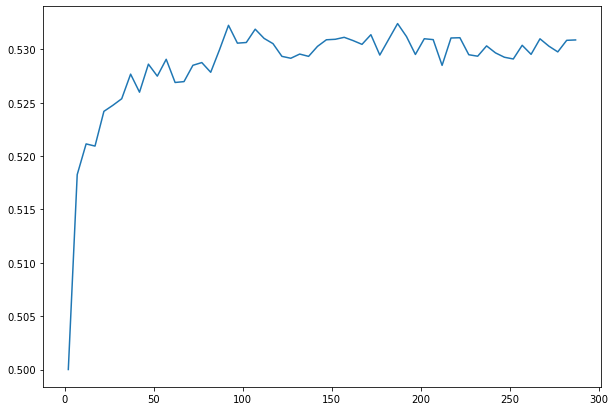

In [37]:
pd.Series(k_vs_score,index=range_procura).plot(figsize=(10,7))

In [38]:
ind = pd.Series(k_vs_score,index=range_procura).sort_values(ascending=False).index[0]
print('Número de variáveis selecionadas: ', ind)

Número de variáveis selecionadas:  187


O algoritmo teve sua melhor performance ao utilizar 187 variáveis. Passaremos essa informação novamente para que o SelectKBest devolva as 187 variáveis que apresentaram a melhor performance.
Definidas as variáveis, definimos as bases de treino e teste.

In [39]:
#Método de Filtro
seletor = SelectKBest(score_func=f_classif, k=ind)
seletor.fit(treino_x, treino_y)
selecionadas = seletor.get_support()
df_vars_filter = pd.Series(seletor.scores_, index=treino_x.columns)[selecionadas].sort_values(ascending=False)
df_vars_filter

ID_MUNICIPIO            616.467
PROF_TX_RESP_Q096       606.360
DIRETOR_TX_RESP_Q086    538.891
DIRETOR_TX_RESP_Q038    521.055
TAXA_PARTICIPACAO_9EF   452.811
                          ...  
DIRETOR_TX_RESP_Q075     30.615
PROF_TX_RESP_Q029        30.116
PROF_TX_RESP_Q038        29.616
TX_RESP_Q017             29.473
PROF_TX_RESP_Q072        29.057
Length: 187, dtype: float64

In [40]:
treino_xf = treino_x[treino_x.columns[selecionadas]]
teste_xf = teste_x[treino_x.columns[selecionadas]]
validacao_xf = validacao_x[treino_x.columns[selecionadas]]
treino_xf.shape, validacao_xf.shape, teste_xf.shape

((27304, 187), (28163, 187), (29714, 187))

### Modelagem

Para otimizar os resultados, estou utilizando uma função de otimização de hyperparâmetros chamada BayesianOptimization.
Essa função visa encontrar, dentro do range indicado, qual a combinação de hiperparâmetros que maximizam a métrica escolhida.
É necessário tomar cuidado com a definição dos ranges para que o modelo não tenha overfting.

In [41]:
def bayes_parameter_opt_lgb(X, y, init_round=10, opt_round=20, n_folds=3, random_seed=42, output_process=False):
    # prepare data
    train_data = lgb.Dataset(X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval( num_leaves, max_depth, learning_rate, lambda_l1, feature_fraction, bagging_fraction,  max_bin, min_data_in_leaf):
      
        params = {'application':'binary', 'metric':'auc', 'verbose' :-1, 'is_unbalance': True}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = min(int(round(num_leaves)),2**(params['max_depth']))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_bin'] = int(round(max_bin))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['lambda_l1'] = max(lambda_l1, 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =False)
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.0001, 0.03),
                                            'num_leaves': (2, 30),
                                            'feature_fraction': (0.1, 0.8),
                                            'bagging_fraction': (0.1, 0.8),
                                            'max_depth': (2, 30),
                                            'max_bin':(2,300),
                                            'lambda_l1': (0, 10),
                                            'min_data_in_leaf': (2, 800)}, random_state=42)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
        
    # return best parameters
    return lgbBO.max

opt_params = bayes_parameter_opt_lgb(treino_xf, treino_y, init_round=10, opt_round=15, n_folds=5, random_seed=42)

|   iter    |  target   | baggin... | featur... | lambda_l1 | learni... |  max_bin  | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8771   |  0.3622   |  0.7655   |  7.32     |  0.018    |  48.49    |  6.368    |  48.35    |  26.25    |
|  2        |  0.8749   |  0.5208   |  0.5957   |  0.2058   |  0.0291   |  250.1    |  7.945    |  147.1    |  7.135    |
|  3        |  0.8692   |  0.313    |  0.4673   |  4.319    |  0.008808 |  184.3    |  5.906    |  235.1    |  12.26    |
|  4        |  0.8632   |  0.4192   |  0.6496   |  1.997    |  0.01548  |  178.5    |  3.301    |  486.8    |  6.775    |
|  5        |  0.8778   |  0.1455   |  0.7642   |  9.656    |  0.02427  |  92.77    |  4.735    |  548.0    |  14.32    |
|  6        |  0.8847   |  0.1854   |  0.4466   |  0.3439   |  0.02729  |  79.12    |  20.55    |  250.7    |  16.56    |
|  7        |  0.8855   

Na 14ª rodada o modelo encontrou a melhor AUC (88,62%) com os parâmetros declarados ao lado. Esses parâmetros serão ajustados para serem utilizados no treinamento do modelo.

In [42]:
params = dict(opt_params['params'])

In [43]:
params["num_leaves"] = int(round(opt_params['params']["num_leaves"]))
params['max_depth'] = int(round(opt_params['params']['max_depth']))
params['min_data_in_leaf'] = int(round(opt_params['params']['min_data_in_leaf']))
params['max_bin'] = int(round(opt_params['params']['max_bin']))
params['objective']='binary'
params['metric']='auc'
params['is_unbalance']=True
params['verbose']=-1
params

{'bagging_fraction': 0.6634005562677355,
 'feature_fraction': 0.2980164923022849,
 'lambda_l1': 8.70807508685366,
 'learning_rate': 0.02857449764033045,
 'max_bin': 283,
 'max_depth': 13,
 'min_data_in_leaf': 478,
 'num_leaves': 24,
 'objective': 'binary',
 'metric': 'auc',
 'is_unbalance': True,
 'verbose': -1}

In [44]:
vFuncPred = np.vectorize(lambda x: 1 if x > 0.5 else 0)

In [45]:
trn_data = lgb.Dataset(treino_xf, label=treino_y, free_raw_data=False)
val_data = lgb.Dataset(validacao_xf, label=validacao_y, free_raw_data=False)

In [46]:
modelo = lgb.train(params, trn_data, valid_sets = [trn_data, val_data], verbose_eval=False, early_stopping_rounds = 20)
probaT = modelo.predict(treino_xf)
probaV = modelo.predict(validacao_xf)
proba = modelo.predict(teste_xf)

preditoT = vFuncPred(probaT)
preditoV = vFuncPred(probaV)
predito = vFuncPred(proba)

print("Score treino: {:<8.5f}".format(roc_auc_score(treino_y, probaT)))
print("Score validação: {:<8.5f}".format(roc_auc_score(validacao_y, probaV)))
print("Score teste: {:<8.5f}".format(roc_auc_score(teste_y, proba)))

print("F1 treino: {:<8.5f}".format(f1_score(treino_y, preditoT)))
print("F1 validação: {:<8.5f}".format(f1_score(validacao_y, preditoV)))
print("F1 teste: {:<8.5f}".format(f1_score(teste_y, predito)))

print("cm treino: \n{}".format(confusion_matrix(treino_y, preditoT)))
print("cm validação: \n{}".format(confusion_matrix(validacao_y, preditoV)))
print("cm teste: \n{}".format(confusion_matrix(teste_y, predito)))


Score treino: 0.93718 
Score validação: 0.84703 
Score teste: 0.82027 
F1 treino: 0.38169 
F1 validação: 0.41737 
F1 teste: 0.50099 
cm treino: 
[[21754  4057]
 [  184  1309]]
cm validação: 
[[21967  3531]
 [ 1031  1634]]
cm teste: 
[[21384  3182]
 [ 2364  2784]]


In [47]:
print(classification_report(teste_y, predito))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     24566
           1       0.47      0.54      0.50      5148

    accuracy                           0.81     29714
   macro avg       0.68      0.71      0.69     29714
weighted avg       0.83      0.81      0.82     29714



O modelo apresentou um pouco de overfting quando comparamos teste e validação, porém entre validação e teste os resultados ficaram bem parecidos.

#### Importâncias das variáveis

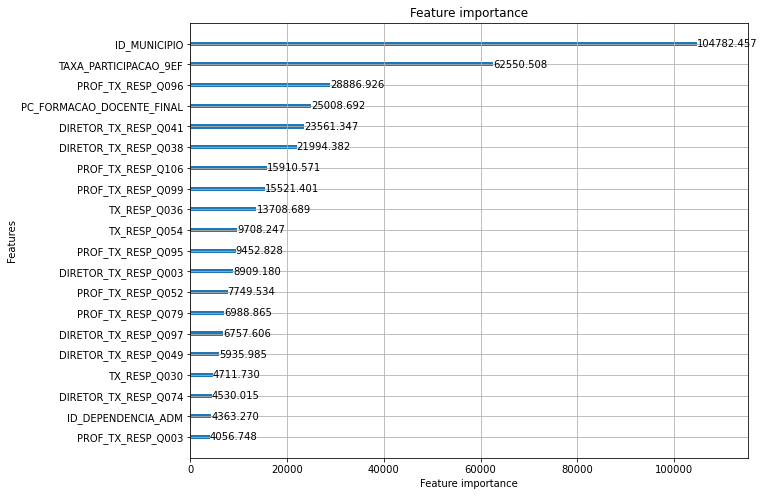

In [48]:
lgb.plot_importance(modelo, figsize=(10,8), importance_type='gain', max_num_features=20)

O LightGBM indica que as variáveis mais importantes são código do município, taxa de participação e algumas outras dos questionários. 
Vou agora utilizar a biblioteca Shap para interpretar melhor como os valores de cada variáveis interferem no modelo.

C:\Users\misan\anaconda3\lib\site-packages\shap\explainers\tree.py:194: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


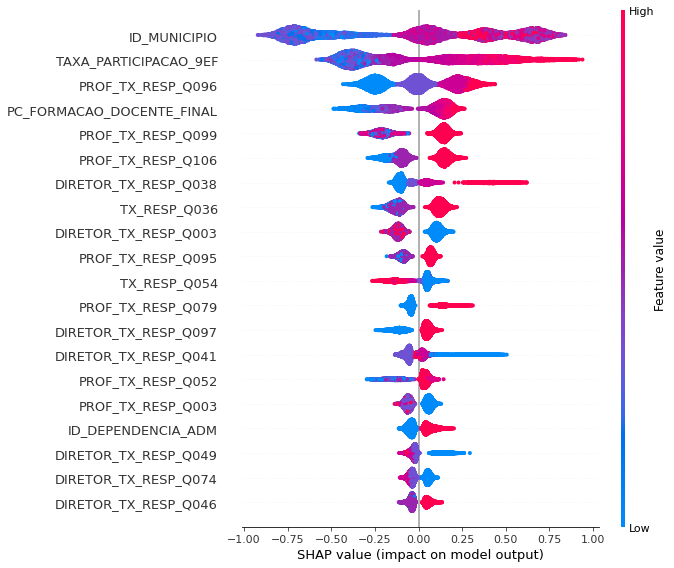

In [49]:
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(treino_xf)
ordem_vars = np.argsort(np.sum(np.abs(shap_values[1]), axis=0))[::-1]
shap.summary_plot(shap_values[1], treino_xf)

Quanto mais alongada a linha, maior a relevância da variável para o modelo, mais ela discrimina os resultados. E as cores indicam o valor contido em cada variável e como ele contribui para o modelo (a esquerda indica que seria a target 0, e a direita, target 1).

Portanto podemos interpretar que quanto menor o código do municipio e a taxa de participação (mais azuis), pior é o aprendizado.

Vamos ainda estudar um pouco mais estes resultados, porém vamos tentar melhorar os resultados do modelo realizando o UnderSampling e OverSampling.

# UnderSampling

In [50]:
treino_x_us, treino_y_us = RandomUnderSampler(random_state=42).fit_resample(treino_xf, treino_y)

print(Counter(treino_y_us))
print(Counter(treino_y))

Counter({0: 1493, 1: 1493})
Counter({0: 25811, 1: 1493})


In [51]:
def bayes_parameter_opt_lgb_bal(X, y, init_round=10, opt_round=20, n_folds=3, random_seed=42, output_process=False):
    # prepare data
    train_data = lgb.Dataset(X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval( num_leaves, max_depth, learning_rate, lambda_l1, feature_fraction, bagging_fraction,  max_bin, min_data_in_leaf):
#       , 'is_unbalance': True
        params = {'application':'binary', 'metric':'auc', 'verbose' :-1}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = min(int(round(num_leaves)),2**(params['max_depth']))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_bin'] = int(round(max_bin))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['lambda_l1'] = max(lambda_l1, 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =False)
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.0001, 0.03),
                                            'num_leaves': (2, 30),
                                            'feature_fraction': (0.1, 0.8),
                                            'bagging_fraction': (0.1, 0.8),
                                            'max_depth': (2, 30),
                                            'max_bin':(2,300),
                                            'lambda_l1': (0, 10),
                                            'min_data_in_leaf': (2, 800)}, random_state=42)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
        
    # return best parameters
    return lgbBO.max

opt_params_us = bayes_parameter_opt_lgb_bal(treino_x_us, treino_y_us, init_round=10, opt_round=15, n_folds=5, random_seed=42)

|   iter    |  target   | baggin... | featur... | lambda_l1 | learni... |  max_bin  | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8581   |  0.3622   |  0.7655   |  7.32     |  0.018    |  48.49    |  6.368    |  48.35    |  26.25    |
|  2        |  0.866    |  0.5208   |  0.5957   |  0.2058   |  0.0291   |  250.1    |  7.945    |  147.1    |  7.135    |
|  3        |  0.8477   |  0.313    |  0.4673   |  4.319    |  0.008808 |  184.3    |  5.906    |  235.1    |  12.26    |
|  4        |  0.8337   |  0.4192   |  0.6496   |  1.997    |  0.01548  |  178.5    |  3.301    |  486.8    |  6.775    |
|  5        |  0.8413   |  0.1455   |  0.7642   |  9.656    |  0.02427  |  92.77    |  4.735    |  548.0    |  14.32    |
|  6        |  0.8658   |  0.1854   |  0.4466   |  0.3439   |  0.02729  |  79.12    |  20.55    |  250.7    |  16.56    |
|  7        |  0.855    

In [52]:
params_us = dict(opt_params_us['params'])

In [53]:
params_us["num_leaves"] = int(round(opt_params_us['params']["num_leaves"]))
params_us['max_depth'] = int(round(opt_params_us['params']['max_depth']))
params_us['min_data_in_leaf'] = int(round(opt_params_us['params']['min_data_in_leaf']))
params_us['max_bin'] = int(round(opt_params_us['params']['max_bin']))
params_us['objective']='binary'
params_us['metric']='auc'
params_us['verbose']=-1
params_us

{'bagging_fraction': 0.7596044103165079,
 'feature_fraction': 0.20949879744101962,
 'lambda_l1': 6.703979257633068,
 'learning_rate': 0.022945331518368733,
 'max_bin': 233,
 'max_depth': 23,
 'min_data_in_leaf': 136,
 'num_leaves': 15,
 'objective': 'binary',
 'metric': 'auc',
 'verbose': -1}

In [54]:
trn_data = lgb.Dataset(treino_x_us, label=treino_y_us)

In [55]:
modelo_us = lgb.train(params_us, trn_data, valid_sets = [trn_data, val_data], verbose_eval=False, early_stopping_rounds = 20)
probaT_us = modelo_us.predict(treino_xf)
probaV_us = modelo_us.predict(validacao_xf)
proba_us = modelo_us.predict(teste_xf)

preditoT_us = vFuncPred(probaT_us)
preditoV_us = vFuncPred(probaV_us)
predito_us = vFuncPred(proba_us)

print("Score treino: {:<8.5f}".format(roc_auc_score(treino_y, probaT_us)))
print("Score validação: {:<8.5f}".format(roc_auc_score(validacao_y, probaV_us)))
print("Score teste: {:<8.5f}".format(roc_auc_score(teste_y, proba_us)))

print("F1 treino: {:<8.5f}".format(f1_score(treino_y, preditoT_us)))
print("F1 validação: {:<8.5f}".format(f1_score(validacao_y, preditoV_us)))
print("F1 teste: {:<8.5f}".format(f1_score(teste_y, predito_us)))

print("cm treino: \n{}".format(confusion_matrix(treino_y, preditoT_us)))
print("cm validação: \n{}".format(confusion_matrix(validacao_y, preditoV_us)))
print("cm teste: \n{}".format(confusion_matrix(teste_y, predito_us)))

Score treino: 0.89258 
Score validação: 0.83267 
Score teste: 0.80590 
F1 treino: 0.30390 
F1 validação: 0.39316 
F1 teste: 0.48986 
cm treino: 
[[20456  5355]
 [  266  1227]]
cm validação: 
[[20970  4528]
 [  905  1760]]
cm teste: 
[[20595  3971]
 [ 2190  2958]]


In [56]:
print(classification_report(teste_y, predito_us))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87     24566
           1       0.43      0.57      0.49      5148

    accuracy                           0.79     29714
   macro avg       0.67      0.71      0.68     29714
weighted avg       0.82      0.79      0.80     29714



# OverSampling

In [57]:
# tratando desbalanceamento. 1 para oversampling, gerando novos dados para a variável target =1
treino_x_os, treino_y_os = RandomOverSampler(random_state=42).fit_resample(treino_xf, treino_y)

print(Counter(treino_y_os))
print(Counter(treino_y))

Counter({0: 25811, 1: 25811})
Counter({0: 25811, 1: 1493})


In [58]:
opt_params_os = bayes_parameter_opt_lgb_bal(treino_x_os, treino_y_os, init_round=10, opt_round=15, n_folds=5, random_seed=42)

|   iter    |  target   | baggin... | featur... | lambda_l1 | learni... |  max_bin  | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9173   |  0.3622   |  0.7655   |  7.32     |  0.018    |  48.49    |  6.368    |  48.35    |  26.25    |
|  2        |  0.8868   |  0.5208   |  0.5957   |  0.2058   |  0.0291   |  250.1    |  7.945    |  147.1    |  7.135    |
|  3        |  0.8805   |  0.313    |  0.4673   |  4.319    |  0.008808 |  184.3    |  5.906    |  235.1    |  12.26    |
|  4        |  0.8649   |  0.4192   |  0.6496   |  1.997    |  0.01548  |  178.5    |  3.301    |  486.8    |  6.775    |
|  5        |  0.9023   |  0.1455   |  0.7642   |  9.656    |  0.02427  |  92.77    |  4.735    |  548.0    |  14.32    |
|  6        |  0.9166   |  0.1854   |  0.4466   |  0.3439   |  0.02729  |  79.12    |  20.55    |  250.7    |  16.56    |
|  7        |  0.9262   

In [59]:
params_os = dict(opt_params_os['params'])

In [60]:
params_os["num_leaves"] = int(round(opt_params_os['params']["num_leaves"]))
params_os['max_depth'] = int(round(opt_params_os['params']['max_depth']))
params_os['min_data_in_leaf'] = int(round(opt_params_os['params']['min_data_in_leaf']))
params_os['max_bin'] = int(round(opt_params_os['params']['max_bin']))
params_os['objective']='binary'
params_os['metric']='auc'
params_os['verbose']=-1
params_os

{'bagging_fraction': 0.5700145601811708,
 'feature_fraction': 0.17021067096251494,
 'lambda_l1': 3.93820281694092,
 'learning_rate': 0.019921599837139398,
 'max_bin': 234,
 'max_depth': 18,
 'min_data_in_leaf': 198,
 'num_leaves': 29,
 'objective': 'binary',
 'metric': 'auc',
 'verbose': -1}

In [61]:
trn_data = lgb.Dataset(treino_x_os, label=treino_y_os)

In [62]:
modelo_os = lgb.train(params_os, trn_data, valid_sets = [trn_data, val_data], verbose_eval=False, early_stopping_rounds = 20)
probaT_os = modelo_os.predict(treino_xf)
probaV_os = modelo_os.predict(validacao_xf)
proba_os = modelo_os.predict(teste_xf)

preditoT_os = vFuncPred(probaT_os)
preditoV_os = vFuncPred(probaV_os)
predito_os = vFuncPred(proba_os)

print("Score treino: {:<8.5f}".format(roc_auc_score(treino_y, probaT_os)))
print("Score validação: {:<8.5f}".format(roc_auc_score(validacao_y, probaV_os)))
print("Score teste: {:<8.5f}".format(roc_auc_score(teste_y, proba_os)))

print("F1 treino: {:<8.5f}".format(f1_score(treino_y, preditoT_os)))
print("F1 validação: {:<8.5f}".format(f1_score(validacao_y, preditoV_os)))
print("F1 teste: {:<8.5f}".format(f1_score(teste_y, predito_os)))

print("cm treino: \n{}".format(confusion_matrix(treino_y, preditoT_os)))
print("cm validação: \n{}".format(confusion_matrix(validacao_y, preditoV_os)))
print("cm teste: \n{}".format(confusion_matrix(teste_y, predito_os)))


Score treino: 0.93141 
Score validação: 0.83765 
Score teste: 0.81492 
F1 treino: 0.36804 
F1 validação: 0.40759 
F1 teste: 0.49746 
cm treino: 
[[21504  4307]
 [  185  1308]]
cm validação: 
[[21701  3797]
 [ 1011  1654]]
cm teste: 
[[21423  3143]
 [ 2403  2745]]


In [63]:
print(classification_report(teste_y, predito_os))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     24566
           1       0.47      0.53      0.50      5148

    accuracy                           0.81     29714
   macro avg       0.68      0.70      0.69     29714
weighted avg       0.82      0.81      0.82     29714



# Cluster

Com os resultados do shap vou utilizar o algoritmo Kmeans para tentar segmentar as escolas com aprendizado adequado ou não. Para depois, utilizando o SkopeRules, traduzir as regras de cada cluster.

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from IPython.display import display_html

In [65]:
print('Total: ', shap_values[1].shape)
tamanho_amostra = int(shap_values[1].shape[0]*0.5)
print('50%: ', tamanho_amostra)
random_indices = np.random.choice(shap_values[1].shape[0], size=tamanho_amostra, replace=False)
X = shap_values[1][random_indices,:]

Total:  (27304, 187)
50%:  13652


In [66]:
Xf = treino_xf.iloc[random_indices,:]
print('Amostra treino_xf: ', Xf.shape)

Amostra treino_xf:  (13652, 187)


In [67]:
kw = {'random_state': 42}
# X = shap_values[1]

inertia = []
silhueta = []
for i in list(range(2,11)): 
    km = KMeans(n_clusters=i, **kw)
    km.fit(X)
    inertia.append(km.inertia_)
    silhueta.append(silhouette_score(X, km.labels_, random_state=42))

Inertia


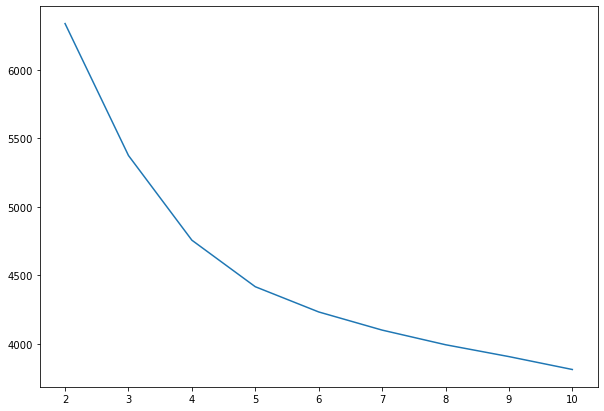

In [68]:
print('Inertia')
pd.Series(inertia, range(2,11)).plot(figsize=(10,7))

Silhouette


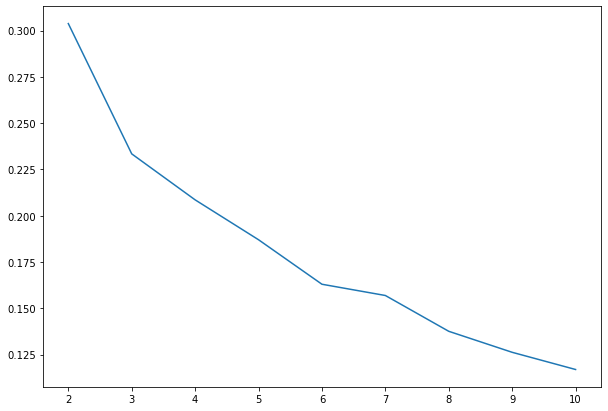

In [69]:
print('Silhouette')
pd.Series(silhueta, range(2,11)).plot(figsize=(10,7))

Silhuete score indica que o melhor número de cluster é 2.

In [70]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, **kw)
kmeans.fit(shap_values[1])

KMeans(n_clusters=2, random_state=42)

Defini uma função que vai separar os dados de cada cluster e aplicar o algoritmo SkopeRules. Este algoritmo (de árvore) traduz as regras que ele encontrou em cada cluster. Ele também informa o quanto a regra informada está coerente com o cluster.

In [71]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [72]:
from skrules import SkopeRules

In [73]:
def get_cluster_rules(algo, X, topk=None, fillna=-999):
    if topk is not None:
        topk_feats = X.columns[feature_order[:topk]].values
    else:
        topk_feats = X.columns
        
    rules_query = dict()
    for i_cluster in np.unique(kmeans.labels_):
        X_rules = X[topk_feats]
        y_rules = (algo.labels_ == i_cluster)*1
        skope_rules_clf = SkopeRules(
            feature_names=topk_feats,
            random_state=42,
            n_estimators=30,
            recall_min=0.5,
            precision_min=0.5,
            max_depth_duplication=3,
            min_samples_split=300,
            max_samples=0.8,
            max_depth=4
        )
        
        skope_rules_clf.fit(X_rules.fillna(fillna), y_rules)
        rules_query[i_cluster] = skope_rules_clf.rules_[0][0]
        print('Cluster ' , i_cluster)
        print(skope_rules_clf.rules_)
        print()
        
    return rules_query

In [74]:
kmeans_rules = get_cluster_rules(kmeans, treino_xf, topk=None)

Cluster  0
[('ID_MUNICIPIO > 2933356.5', (0.9999286399368542, 1.0, 8)), ('ID_MUNICIPIO > 2933381.0 and TX_RESP_Q042 <= 3.5', (1.0, 0.9921187560019452, 14))]

Cluster  1
[('ID_MUNICIPIO <= 2933356.5', (1.0, 0.9999000676474918, 46))]



In [75]:
kmeans_rules

{0: 'ID_MUNICIPIO > 2933356.5', 1: 'ID_MUNICIPIO <= 2933356.5'}

As regras se basearam no código de município. O código delimita o município da Bahia (UF 29), ou seja, municpios das regiões Norte e Nordeste não tem aprendizado adequado, enquanto os demais tem.

### Testar regras

Aplica regras no dataframe original.

In [76]:
def evaluate_rules(rules, df, fillna=-999):
    df_clust = df.copy()
    df_clust['cluster'] = 'Outros'
    
    for cluster, rule in rules.items():
        mask = df_clust.fillna(fillna).eval(rule)
        df_clust.loc[mask, 'cluster'] = str(cluster)
        
    return df_clust

In [77]:
df_kmeans = evaluate_rules(kmeans_rules, df_limpo)

In [78]:
top_7 = list(treino_xf.columns[ordem_vars[:7]])
df_kmeans.groupby('cluster')[['TARGET'] + top_7].mean()

,TARGET,ID_MUNICIPIO,TAXA_PARTICIPACAO_9EF,PROF_TX_RESP_Q096,PC_FORMACAO_DOCENTE_FINAL,PROF_TX_RESP_Q099,PROF_TX_RESP_Q106,DIRETOR_TX_RESP_Q038
cluster,,,,,,,,
0,0.156,"3,869,229.599",0.832,1.148,65.125,3.288,3.309,0.857
1,0.041,"2,276,096.167",0.856,1.192,40.062,3.205,3.108,0.749


Depois de aplicadas as regras, quis entender qual valor das 7 variáveis mais importantes pro modelo para cada cluster.

Fica nitica a diferença da variável target, temos muito mais escolas com aprendizado adequado no cluster 0 (15,6%). Já a taxa de partipação é semelhante, e está até menor no cluster 0. Já o Percentual de Formação está bem diferente, 25 p.p acima do cluster 1.

As variáveis dos questionários precisam ser interpretadas separadamente, olhando o shap e a descrição de cada um e que letra representa cada valor.

In [79]:
df_kmeans['cluster_num'] = df_kmeans['cluster'].astype('int')

In [90]:
df_final = df_kmeans[treino_x.columns[selecionadas]]
df_final.shape

(85181, 187)

In [91]:
df_kmeans['proba'] = modelo.predict(df_final)
df_kmeans.shape

(85181, 314)

In [92]:
df_kmeans['predito'] = df_kmeans['proba'].apply(lambda x: 1 if x > 0.5 else 0)
df_kmeans.shape

(85181, 315)

In [93]:
df_kmeans['ID_UF'] = df['ID_UF']
df_kmeans.shape

(85181, 316)

In [94]:
df_kmeans.to_csv('ABT_FINAL.csv')

Adiciona variáveis de resposta do modelo e UF e salva a base. Essa base será utilizada para geração dos mapas e entendimento dos resultados.